# Projet appartment-hunter - La plateforme

## Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

# Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# ml tools
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, learning_curve, validation_curve, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from statsmodels.stats.outliers_influence import variance_inflation_factor
import joblib

# Feature Selection
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from boruta import BorutaPy

# models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import lime
import lime.lime_tabular

# Custom
from functions import load_best_model, save_model_if_best, variance_threshold_selector, KBest_selector

# from sklearn.model_selection import train_test_split, cross_validate, learning_curve, validation_curve, cross_val_score

# from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# from sklearn.tree import DecisionTreeClassifier

# import pickle

# import warnings

# warnings.simplefilter(action='ignore', category=FutureWarning)
# pd.options.mode.chained_assignment = None
# warnings.filterwarnings("ignore", category=RuntimeWarning)
# warnings.filterwarnings("ignore", category=UserWarning)

### Palette

In [4]:

orange = "#FFA500"
purple = "#800080"
grey = "#808080"

custom_palette = ["#FFA500", "#FF8C00", "#FF5500", "#FF2200", "#800040", "#400080", "#800080", "#808080", "#808080"]

custom_palette_f5 = [
    purple   ,  # purple
    '#3B528B',  # Blue
    orange   ,  #orange
    '#21918C',  # Green
    # '#5DC863',  # Yellow-Green
    grey     ,  #grey
    # '#FDE725'   # Yellow
]

viridis_colors = [
    purple   ,  # Purple
    '#3B528B',  # Blue
    '#21918C',  # Green
    '#5DC863',  # Yellow-Green
    '#FDE725'   # Yellow
]

sns.set_palette(custom_palette)

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
df = pd.read_csv('data/cleaned_df.csv')

## Power BI Dashboard Nudes


![Dashboard](Power_BI_Dashboard.png)

## Stay up to date with technology - Regression

Regression is a supervised learning technique for determining the relationship between a dependent variable, y, and one or more independent variables, x. Two common regression algorithms are simple and multiple linear regression.

### Linear Regression

**Linear regression is a type of supervised machine learning algorithm that computes the linear relationship between the dependent variable and one or more independent features by fitting a linear equation to observed data.**

Note : We're going for the most basic model since it is often surprisingly efficient and also will serve as a baseline to discover if it was worth using more complex models to make a prediction instead of going for a simpler answer.
It being linear will obviously deserves us on high end houses where values can have steeper rises, but those products are by definition rares and may not affect our ability to predict the other houses.

### Decision Tree Regressor

**The decision trees is used to fit a sine curve with addition noisy observation. As a result, it learns local linear regressions approximating the sine curve.**

Note : Althought it is prone to overfitting, I think it really delivers a "decision processus" pretty close to what an expert determining the price of a lot would execute to motivate his decision based on pros and cons relative to informations. So we think it is worth trying.

### Ridge Regression (L2 regularization) 

**Ridge regression is a model-tuning method that is used to analyze any data that suffers from multicollinearity. This method performs L2 regularization. When the issue of multicollinearity occurs, least-squares are unbiased, and variances are large, this results in predicted values being far away from the actual values.**

**The cost function for ridge regression:**

$\min_{\theta} \left( ||Y - X\theta||^2 + \lambda||\theta|| \right)$

Note : A safe bet for us is going with a ridge regression that tends to negate some effects of multicolinearity as long as we don't mess up the feature selection, it should cover our projected weakness of picking too many features to work with since many of them have had promising results in colinearity tests with prices.

## Feature Analysis and Selection

### Feature Selection

transformed columns : Year Month Day sqft_basement_class yr_renovated_classes zipcode_class
note : may use sqft_above as sqft_above_bin

***Eye Test for feature selection***

**Most promising:**

- sqft_living 
- sqft_above 
- grade 
- yr_renovated_classes
- zipcode_class

**relevant:**
- bathrooms 
- sqft_basement_class 
- sqft_living15 
 
**Possibly relevant:**
- bedrooms 
- waterfront 
- view 

**Probably won't be relevant**

- Day 
- floors 
- sqft_lot 
- sqft_lot15 
- condition 
- yr_built

**Won't be given a chance**

- Year
- Month

#### Explore options (Boruta, forward feature selection, ...)

In [7]:
clean_df = df.copy()

In [8]:
# to_one_hot_encode = ['zipcode_class']
to_ordinal_encode = ['grade', 'yr_renovated_classes', 'bathrooms', 'sqft_basement_class',\
    'bedrooms', 'waterfront', 'view', 'zipcode_class']
to_scale = ['sqft_living', 'sqft_above', 'sqft_living15']
target = 'price'
select_features = to_ordinal_encode + to_scale + [target]

In [9]:
clean_df = clean_df[select_features]
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19919 entries, 0 to 19918
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   grade                 19919 non-null  int64  
 1   yr_renovated_classes  19919 non-null  int64  
 2   bathrooms             19919 non-null  float64
 3   sqft_basement_class   19919 non-null  int64  
 4   bedrooms              19919 non-null  int64  
 5   waterfront            19919 non-null  int64  
 6   view                  19919 non-null  int64  
 7   zipcode_class         19919 non-null  int64  
 8   sqft_living           19919 non-null  int64  
 9   sqft_above            19919 non-null  int64  
 10  sqft_living15         19919 non-null  int64  
 11  price                 19919 non-null  float64
dtypes: float64(2), int64(10)
memory usage: 1.8 MB


#### VarianceThreshold

In [10]:
pd.options.display.float_format = '{:.2f}'.format

In [11]:
clean_df.var(axis=0)

grade                            1.02
yr_renovated_classes             0.10
bathrooms                        0.48
sqft_basement_class              0.80
bedrooms                         0.72
waterfront                       0.00
view                             0.39
zipcode_class                    1.79
sqft_living                 547298.33
sqft_above                  498129.12
sqft_living15               364887.10
price                  41087895603.28
dtype: float64

For now we'll filter all features with a variance lower to 0.2

In [12]:
clean_df = variance_threshold_selector(clean_df,threshold=0.2)

columns dropped : ['yr_renovated_classes', 'waterfront']


In [13]:
clean_df.var(axis=0)

grade                           1.02
bathrooms                       0.48
sqft_basement_class             0.80
bedrooms                        0.72
view                            0.39
zipcode_class                   1.79
sqft_living                547298.33
sqft_above                 498129.12
sqft_living15              364887.10
price                 41087895603.28
dtype: float64

#### SelectKBest


In [14]:
from sklearn.feature_selection import f_classif
f_classif(clean_df.drop(columns='price'), clean_df.price)

(array([4.8027265 , 2.53206833, 1.3153853 , 1.58590119, 1.25597189,
        7.22442937, 4.58040118, 3.40172286, 3.86978975]),
 array([0.00000000e+00, 0.00000000e+00, 6.54356389e-27, 3.74430647e-75,
        5.02661782e-19, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]))

In [15]:
# at this point of time we have 9 remaining features, we're choosing to cut 3 more.
clean_df = KBest_selector(clean_df, target_name = 'price', k=6)

columns dropped : ['sqft_basement_class', 'bedrooms', 'view']


In [16]:
clean_df.columns

Index(['grade', 'bathrooms', 'zipcode_class', 'sqft_living', 'sqft_above',
       'sqft_living15', 'price'],
      dtype='object')

#### Boruta

In [18]:
# Boruta is not up to date with the latests versions of numpy so we need to do this to fix the int error
np.int = np.int32
np.float = np.float64
np.bool = np.bool_

rf = RandomForestRegressor(n_estimators=200, n_jobs=-1, max_depth=5)

feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)

# find all relevant features
feat_selector.fit(clean_df.drop(columns=['price']).values, clean_df.price.values)

# check selected features
feat_selector.support_

# check ranking of features
# feat_selector.ranking_


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	0


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	0


array([ True,  True,  True,  True,  True,  True])

Boruta gives a pass to all our features.

##### Making a preprocessing pipeline

In [ ]:
# to_one_hot_encode = ['zipcode_class']
to_ordinal_encode = ['grade', 'zipcode_class']
to_scale = ['sqft_living', 'sqft_above', 'sqft_living15']
select_features = to_ordinal_encode + to_scale # already_processed to_label_encode to_one_hot_encode

X = clean_df[select_features]
y = clean_df['price']  # Target

model_name = 'linear'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
    random_state=42) # np.random.randint(1, 20001) 42

# Building Preprocessing Pipeline
preprocessor = ColumnTransformer([
    # ('imputer', SimpleImputer(strategy='most_frequent')),
    # ('onehot', OneHotEncoder(), to_one_hot_encode),
    ('ordinal', OrdinalEncoder(), to_ordinal_encode),
    ('robust_scaler', RobustScaler(), to_scale), # RobustScaler/StandardScaler/MinMaxScaler
], remainder='passthrough')  # passthrough/drop

X_train_selected = pd.DataFrame(preprocessor.fit_transform(X_train),
        columns=preprocessor.get_feature_names_out())
X_test_selected = pd.DataFrame(preprocessor.fit_transform(X_test),
        columns=preprocessor.get_feature_names_out())

##### Forward Feature Selection

Only found a version with warning for now, better keep it than not use it at the moment.

In [ ]:
lreg = LinearRegression()
sfs1 = sfs(lreg, k_features=5, forward=True, verbose=2, scoring='neg_mean_squared_error')
sfs1 = sfs1.fit(X, y)
feat_names = list(sfs1.k_feature_names_)
print('kept features', feat_names)


[2024-04-16 11:31:03] Features: 1/5 -- score: -22171251093.82438
[2024-04-16 11:31:03] Features: 2/5 -- score: -11358702992.547903
[2024-04-16 11:31:03] Features: 3/5 -- score: -10645256226.404724

kept features ['grade', 'zipcode_class', 'sqft_living', 'sqft_above', 'sqft_living15']



[2024-04-16 11:31:03] Features: 4/5 -- score: -10621618292.062778
[2024-04-16 11:31:03] Features: 5/5 -- score: -10603382153.478214

Forward Feature Selection also gives a pass to the 5

#### VIF

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = list(X_train_selected)
vif_data["VIF"] = [variance_inflation_factor(X_train_selected, i)
                          for i in range(len(X_train_selected.columns))]

print('VIF (facteur d\'inflation de la variance)')
print(vif_data)

VIF (facteur d'inflation de la variance)
                        feature       VIF
0                ordinal__grade  4.092220
1        ordinal__zipcode_class  3.359373
2    robust_scaler__sqft_living  4.148563
3     robust_scaler__sqft_above  4.373177
4  robust_scaler__sqft_living15  2.524854


All values are under 10 which indicates a low level of multicolinearity which we may not have to fix.

But we saw in another VIF test with more features that sqft_above and sqft_living had VIF Scores of above 60 earlier, which is something we want to prevent becoming an hidden issue.

In [ ]:
clean_df.sqft_living.mean()

1957.0613986645917

In [ ]:
clean_df.sqft_above.mean()

1695.183442943923

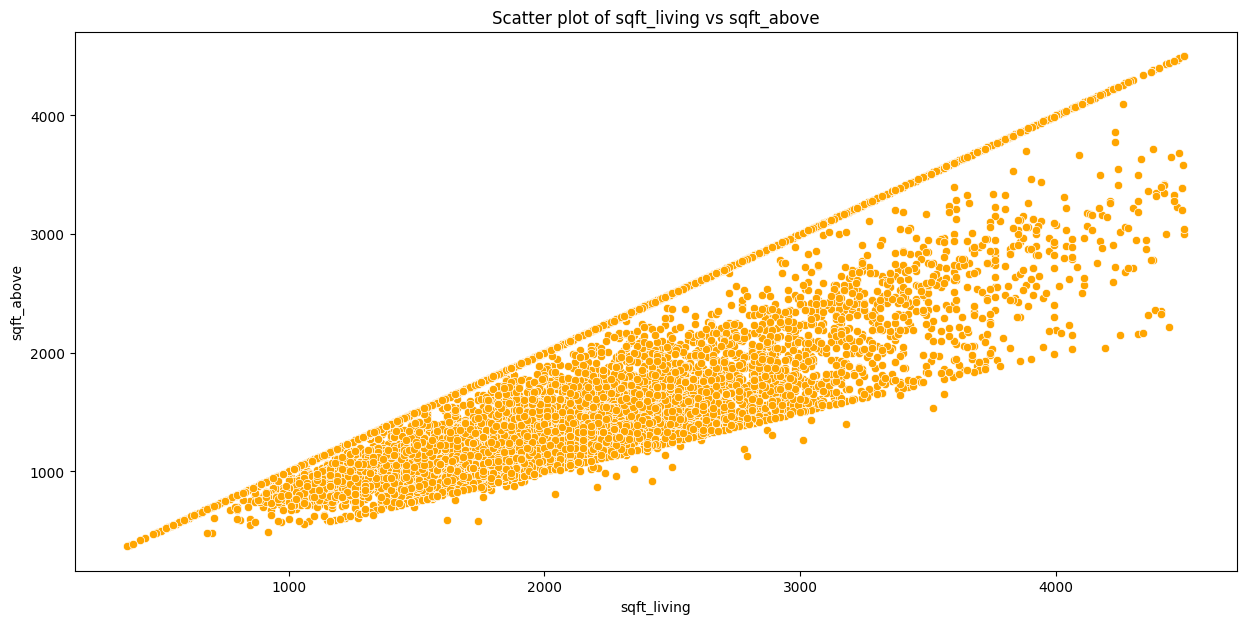

In [ ]:
plt.figure(figsize=(15, 7))

sns.scatterplot(x='sqft_living', y='sqft_above', data=clean_df)

plt.xlabel('sqft_living')
plt.ylabel('sqft_above')
plt.title('Scatter plot of sqft_living vs sqft_above')

plt.show()


We did realize earlier that sqft_living = sqft_above + sqft_basement so we won't be able to  reasonably keep both.

As sqft_above is a component of sqft_living which is somewhat of a pre-engineered feature and with sqft_basement being a valuable kind of living space, **we choose to keep only sqft_living** which is more closely related to sqft_living15 for now and will make some test with sqft_above and both later on.

We made some research which confirmed that basement add value to a house and comforts our choice.

In [ ]:
# to_one_hot_encode = ['zipcode_class'] sent to ordinal
to_ordinal_encode = ['grade', 'bathrooms', 'zipcode_class']
to_scale = ['sqft_living', 'sqft_living15']
select_features = to_ordinal_encode + to_scale # already_processed to_label_encode to_one_hot_encode

X = clean_df[select_features]
y = clean_df['price']  # Target

model_name = 'linear'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
    random_state=42) # np.random.randint(1, 20001) 42

# Building Preprocessing Pipeline
preprocessor = ColumnTransformer([
    # ('imputer', SimpleImputer(strategy='most_frequent')),
    # ('onehot', OneHotEncoder(), to_one_hot_encode),
    ('ordinal', OrdinalEncoder(), to_ordinal_encode),
    ('robust_scaler', RobustScaler(), to_scale), # RobustScaler/StandardScaler/MinMaxScaler
], remainder='passthrough')  # passthrough/drop

X_train_selected = pd.DataFrame(preprocessor.fit_transform(X_train),
        columns=preprocessor.get_feature_names_out())
X_test_selected = pd.DataFrame(preprocessor.fit_transform(X_test),
        columns=preprocessor.get_feature_names_out())

Visualizing how our dataframe was preprocessed

In [ ]:
X_test_selected.head(1)

,ordinal__grade,ordinal__bathrooms,ordinal__zipcode_class,robust_scaler__sqft_living,robust_scaler__sqft_living15
0,3.0,6.0,0.0,1.184466,1.643836


In [ ]:
X_test.head(1)

,grade,bathrooms,zipcode_class,sqft_living,sqft_living15
18205,8,2.5,0,3080,3080


In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = list(X_train_selected)
vif_data["VIF"] = [variance_inflation_factor(X_train_selected, i)
                          for i in range(len(X_train_selected.columns))]

print('VIF (facteur d\'inflation de la variance)')
print(vif_data)

VIF (facteur d'inflation de la variance)
                        feature       VIF
0                ordinal__grade  8.907013
1            ordinal__bathrooms  7.130774
2        ordinal__zipcode_class  3.256897
3    robust_scaler__sqft_living  2.720108
4  robust_scaler__sqft_living15  2.457677


In [ ]:
to_one_hot_encode = ['zipcode_class']
to_ordinal_encode = ['grade']
to_scale = ['sqft_living', 'sqft_living15']
select_features = to_one_hot_encode + to_ordinal_encode + to_scale # already_processed to_label_encode

X = clean_df[select_features]
y = clean_df['price']  # Target

# Let's check the p-values of our features before regularization
ols = sm.OLS(y, sm.add_constant(X)).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                 1.432e+04
Date:                Tue, 16 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:31:04   Log-Likelihood:            -2.5817e+05
No. Observations:               19919   AIC:                         5.163e+05
Df Residuals:                   19914   BIC:                         5.164e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.859e+05   6124.768    -30.355      0.000   -1.98e+05   -1.74e+05
zipcode_class  8.564e+04    570.849    150.021      0.000    8.45e+04    8.68e+04
grade          3.598e+04   1087.751     33.079      0.000    3.38e+04    3.81e+04
sqft_living     101.0381      1.610     62.766      0.000      97.883     104.193
sqft_living15    13.7010      1.898      7.217      0.000       9.980      17.422
==============================================================================
Omnibus:                     2683.149   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5709.695
Skew:                           0.821   Prob(JB):                         0.00
Kurtosis:                       5.045   Cond. No.                     2.45e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.45e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Still No alerting multicolinearity, we goes on to running our first models.

Common sense and our earlier tests established sqft_living to be the most valuable single feature to use for running our first models.

## Machine Learning with Grid Search and a single feature

### Baseline

In [ ]:
# rmse_scorer = make_scorer(lambda y_true,y_pred : round(np.sqrt(mean_squared_error(y_true, y_pred))))

def rmse(y_true, y_pred):
    return round(np.sqrt(mean_squared_error(y_true, y_pred)))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [ ]:
select_features = ['sqft_living']
X = clean_df[select_features]
y = clean_df['price']

preprocessor = ColumnTransformer([
     ('robust_scaler', RobustScaler(), select_features), # RobustScaler/StandardScaler/MinMaxScaler
     ], remainder='drop')

pipe_baseline = Pipeline([
     ('preprocessor', preprocessor),
     ('linear_reg', LinearRegression())
])

In [ ]:
score_baseline = cross_val_score(pipe_baseline,X, y, cv=5, scoring=rmse_scorer,n_jobs=-1).mean()
score_baseline

-160665.2

So we are aiming for a better rmse score than -160665

### Linear Regression

In [ ]:
# to_ordinal_encode = ['grade', 'bathrooms', 'zipcode_class']
to_scale = ['sqft_living'] #sqft_living15
select_features = to_scale  #to_ordinal_encode

model_name = 'linear'
rmse_list = []
for i in range(1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001)) # np.random.randint(1, 20001) 42

    # Building Pipeline
    preprocessor = ColumnTransformer([
        # ('imputer', SimpleImputer(strategy='most_frequent')),
        # ('onehot', OneHotEncoder(), to_one_hot_encode),
        # ('ordinal', OrdinalEncoder(), to_ordinal_encode),
        ('robust_scaler', RobustScaler(), to_scale), # RobustScaler/StandardScaler/MinMaxScaler
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('linear_reg', LinearRegression())
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid={
            'linear_reg__fit_intercept': [True, False]
        },
        cv=5,
        scoring="neg_root_mean_squared_error")

    grid_search.fit(X_train, y_train)
    pipeline_tuned = grid_search.best_estimator_
    # pipeline.fit(X_train, y_train)

    # Is there a missing transform ? don't think so.
    predicted_price = pipeline_tuned.predict(X_test)

    rmse_score = round(np.sqrt(mean_squared_error(y_test, predicted_price)))
    rmse_list.append(rmse_score)
    save_model_if_best(rmse_score, pipeline_tuned, model_name)

# Display RMSE
print(f"# Average prediction error: ~{round(np.mean(rmse_list)):.4f} (RMSE) (min-max:{round(min(rmse_list))}-{round(max(rmse_list))}), {np.mean(rmse_list)/clean_df.price.mean()*100}% of average price")

print(f"# Used features : {len(select_features) } - {select_features}") #/len(df.columns)

103627
# Average prediction error: ~103627.0000 (RMSE) (min-max:103627-103627), 21.86828555216968% of average price
# Used features : 1 - ['sqft_living']


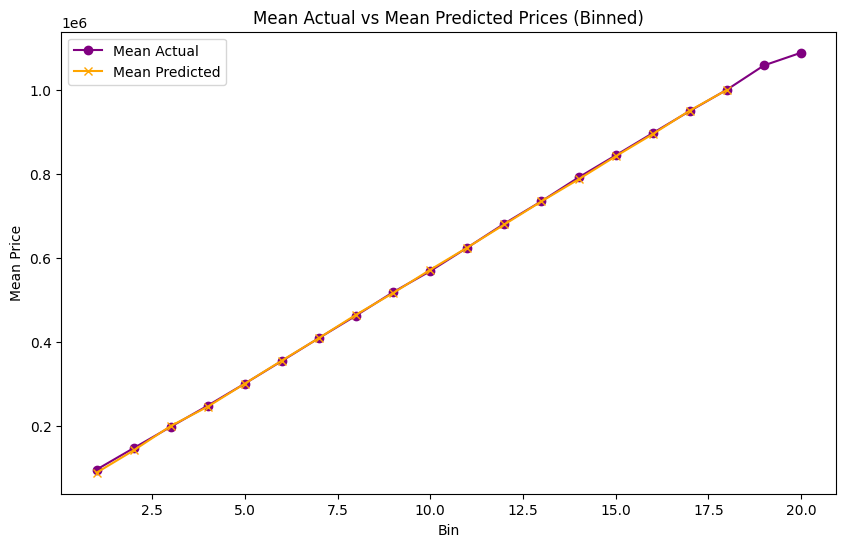

In [ ]:
import matplotlib.pyplot as plt

# Assuming `predicted_price` contains your predictions
# Assuming `y_test` contains the actual values

# Sort the actual values based on the index
y_test_sorted = y_test.sort_index()

# Sort the predicted values based on the index
predicted_price_sorted = pd.Series(predicted_price, index=y_test.index).sort_index()

import numpy as np

# Number of bins
num_bins = 20

# Calculate bin edges
bin_edges = np.linspace(min(y_test_sorted.min(), predicted_price_sorted.min()),
                        max(y_test_sorted.max(), predicted_price_sorted.max()),
                        num=num_bins)

# Calculate bin indices for actual and predicted prices
y_test_bins = np.digitize(y_test_sorted, bin_edges)
predicted_price_bins = np.digitize(predicted_price_sorted, bin_edges)

# Calculate mean actual and predicted prices for each bin
mean_actual = [y_test_sorted[y_test_bins == i].mean() for i in range(1, num_bins + 1)]
mean_predicted = [predicted_price_sorted[predicted_price_bins == i].mean() for i in range(1, num_bins + 1)]

# Plotting the mean actual vs mean predicted values for each bin
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_bins + 1), mean_actual, label='Mean Actual', color='purple', marker='o')
plt.plot(range(1, num_bins + 1), mean_predicted, label='Mean Predicted', marker='x')
plt.xlabel('Bin')
plt.ylabel('Mean Price')
plt.title('Mean Actual vs Mean Predicted Prices (Binned)')
plt.legend()
plt.show()


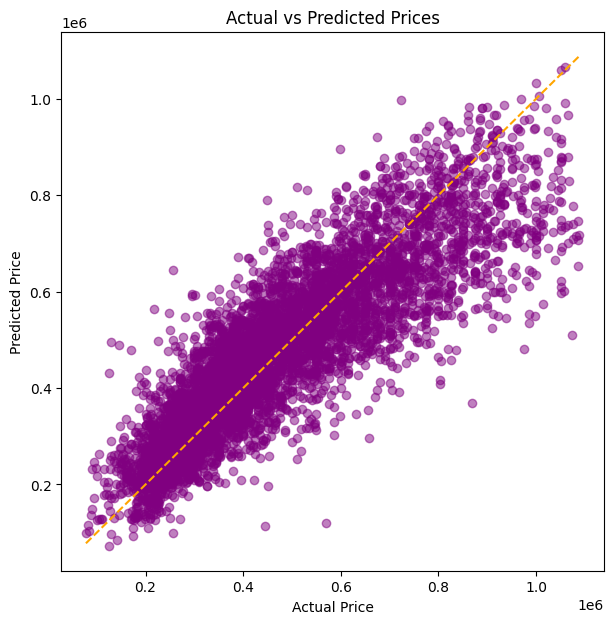

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(y_test, predicted_price, color='purple',alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='orange', linestyle='--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()


In [ ]:
grid_search.best_params_

{'linear_reg__fit_intercept': False}

In [ ]:
cross_val_score(pipeline_tuned, X_test, y_test, scoring = 'neg_root_mean_squared_error').mean() # neg_mean_absolute_error neg_root_mean_squared_error

-103253.56063039586

### Ridge

In [ ]:
# to_ordinal_encode = ['grade', 'bathrooms', 'zipcode_class']
to_scale = ['sqft_living'] #sqft_living15
select_features = to_scale  #to_ordinal_encode

model_name = 'ridge'
rmse_list = []
for i in range(1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001)) # np.random.randint(1, 20001) 42

    # Building Pipeline
    preprocessor = ColumnTransformer([
        # ('imputer', SimpleImputer(strategy='most_frequent')),
        # ('onehot', OneHotEncoder(), to_one_hot_encode),
        # ('ordinal', OrdinalEncoder(), to_ordinal_encode),
        ('robust_scaler', RobustScaler(), to_scale), # RobustScaler/StandardScaler/MinMaxScaler
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('ridge', Ridge())
    ])

#fit

    grid_search = GridSearchCV(
        pipeline,
        param_grid={
            'ridge__alpha'           : [50, 10, 1, 0.1,0.01,0],
            "ridge__fit_intercept"   : [True, False],
            "ridge__solver"          : ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
            "ridge__max_iter"        : [10000]
        },
        cv=5,
        scoring="neg_root_mean_squared_error")

    grid_search.fit(X_train, y_train)
    pipeline_tuned = grid_search.best_estimator_
    # pipeline.fit(X_train, y_train)

    # Is there a missing transform ? don't think so.
    predicted_price = pipeline_tuned.predict(X_test)

    rmse_score = round(np.sqrt(mean_squared_error(y_test, predicted_price)))
    rmse_list.append(rmse_score)
    save_model_if_best(rmse_score, pipeline_tuned, model_name)

# Display RMSE
print(f"# Average prediction error: ~{round(np.mean(rmse_list)):.4f} (RMSE) (min-max:{round(min(rmse_list))}-{round(max(rmse_list))}), {np.mean(rmse_list)/clean_df.price.mean()*100}% of average price")

print(f"# Used features : {len(select_features) } - {select_features}") #/len(df.columns)

# Average prediction error: ~104259.0000 (RMSE) (min-max:104259-104259), 22.00165577874163% of average price
# Used features : 1 - ['sqft_living']


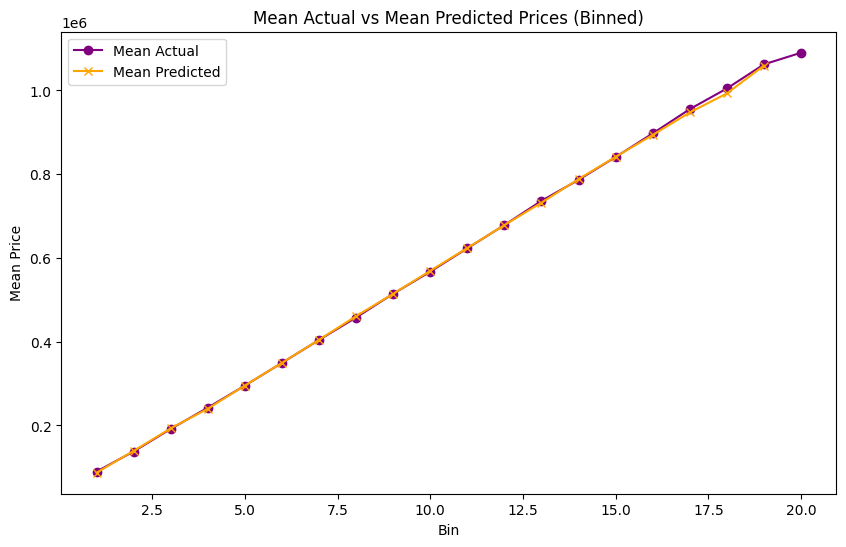

In [ ]:
import matplotlib.pyplot as plt

# Assuming `predicted_price` contains your predictions
# Assuming `y_test` contains the actual values

# Sort the actual values based on the index
y_test_sorted = y_test.sort_index()

# Sort the predicted values based on the index
predicted_price_sorted = pd.Series(predicted_price, index=y_test.index).sort_index()

import numpy as np

# Number of bins
num_bins = 20

# Calculate bin edges
bin_edges = np.linspace(min(y_test_sorted.min(), predicted_price_sorted.min()),
                        max(y_test_sorted.max(), predicted_price_sorted.max()),
                        num=num_bins)

# Calculate bin indices for actual and predicted prices
y_test_bins = np.digitize(y_test_sorted, bin_edges)
predicted_price_bins = np.digitize(predicted_price_sorted, bin_edges)

# Calculate mean actual and predicted prices for each bin
mean_actual = [y_test_sorted[y_test_bins == i].mean() for i in range(1, num_bins + 1)]
mean_predicted = [predicted_price_sorted[predicted_price_bins == i].mean() for i in range(1, num_bins + 1)]

# Plotting the mean actual vs mean predicted values for each bin
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_bins + 1), mean_actual, label='Mean Actual', color='purple', marker='o')
plt.plot(range(1, num_bins + 1), mean_predicted, label='Mean Predicted', marker='x')
plt.xlabel('Bin')
plt.ylabel('Mean Price')
plt.title('Mean Actual vs Mean Predicted Prices (Binned)')
plt.legend()
plt.show()


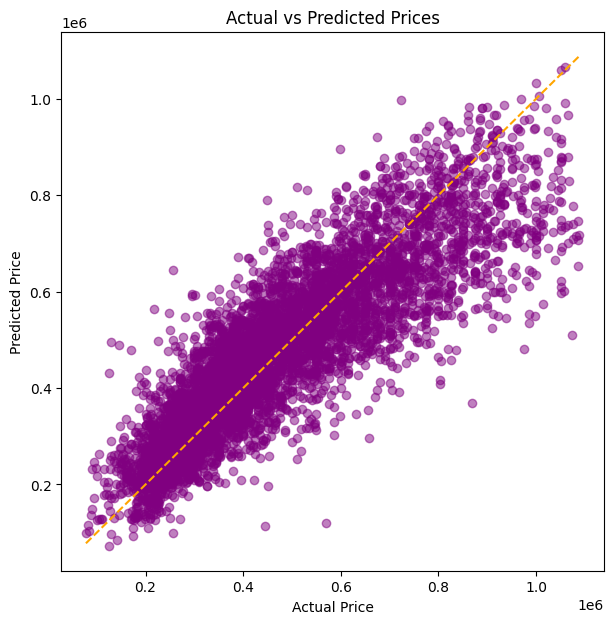

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(y_test, predicted_price, color='purple',alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='orange', linestyle='--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()


In [ ]:
grid_search.best_params_

{'ridge__alpha': 10,
 'ridge__fit_intercept': True,
 'ridge__max_iter': 10000,
 'ridge__solver': 'svd'}

In [ ]:
cross_val_score(pipeline_tuned, X_test, y_test, scoring = 'neg_root_mean_squared_error').mean() # neg_mean_absolute_error neg_root_mean_squared_error

-148260.66655002878

### DecisionTreeRegressor

In [ ]:
# to_ordinal_encode = ['grade', 'bathrooms', 'zipcode_class']
to_scale = ['sqft_living'] #sqft_living15
select_features = to_scale  #to_ordinal_encode

model_name = 'decisionTree'
rmse_list = []
for i in range(1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001)) # np.random.randint(1, 20001) 42

    # Building Pipeline
    preprocessor = ColumnTransformer([
        # ('imputer', SimpleImputer(strategy='most_frequent')),
        # ('onehot', OneHotEncoder(), to_one_hot_encode),
        # ('ordinal', OrdinalEncoder(), to_ordinal_encode),
        ('robust_scaler', RobustScaler(), to_scale), # RobustScaler/StandardScaler/MinMaxScaler
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('decision_tree', DecisionTreeRegressor())
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid={
            "decision_tree__splitter":["best","random"],
            "decision_tree__max_depth" : [1,3,5],
            "decision_tree__min_samples_leaf":[1,3,5],
            "decision_tree__min_weight_fraction_leaf":[0.1,0.2,0.5],
            "decision_tree__max_features":["log2","sqrt",None, 0.1, 1, 10],
            "decision_tree__max_leaf_nodes":[None,10,30,50]
        },
        cv=5,
        scoring="neg_root_mean_squared_error")

    grid_search.fit(X_train, y_train)
    pipeline_tuned = grid_search.best_estimator_
    # pipeline.fit(X_train, y_train)

    # Is there a missing transform ? don't think so.
    predicted_price = pipeline_tuned.predict(X_test)

    rmse_score = round(np.sqrt(mean_squared_error(y_test, predicted_price)))
    rmse_list.append(rmse_score)
    save_model_if_best(rmse_score, pipeline_tuned, model_name)

# Display RMSE
print(f"# Average prediction error: ~{round(np.mean(rmse_list)):.4f} (RMSE) (min-max:{round(min(rmse_list))}-{round(max(rmse_list))}), {np.mean(rmse_list)/clean_df.price.mean()*100}% of average price")

print(f"# Used features : {len(select_features) } - {select_features}") #/len(df.columns)

125556
# Average prediction error: ~125556.0000 (RMSE) (min-max:125556-125556), 26.495936973840955% of average price
# Used features : 1 - ['sqft_living']


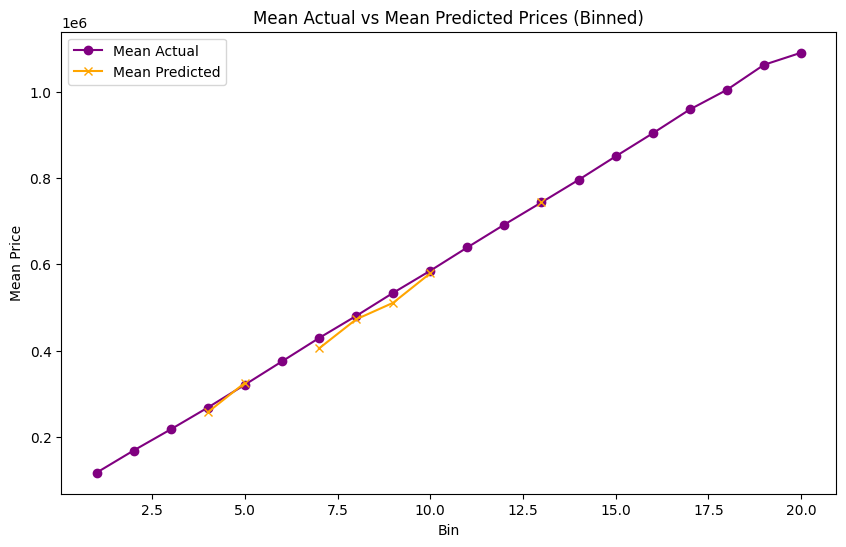

In [ ]:
import matplotlib.pyplot as plt

# Assuming `predicted_price` contains your predictions
# Assuming `y_test` contains the actual values

# Sort the actual values based on the index
y_test_sorted = y_test.sort_index()

# Sort the predicted values based on the index
predicted_price_sorted = pd.Series(predicted_price, index=y_test.index).sort_index()

import numpy as np

# Number of bins
num_bins = 20

# Calculate bin edges
bin_edges = np.linspace(min(y_test_sorted.min(), predicted_price_sorted.min()),
                        max(y_test_sorted.max(), predicted_price_sorted.max()),
                        num=num_bins)

# Calculate bin indices for actual and predicted prices
y_test_bins = np.digitize(y_test_sorted, bin_edges)
predicted_price_bins = np.digitize(predicted_price_sorted, bin_edges)

# Calculate mean actual and predicted prices for each bin
mean_actual = [y_test_sorted[y_test_bins == i].mean() for i in range(1, num_bins + 1)]
mean_predicted = [predicted_price_sorted[predicted_price_bins == i].mean() for i in range(1, num_bins + 1)]

# Plotting the mean actual vs mean predicted values for each bin
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_bins + 1), mean_actual, label='Mean Actual', color='purple', marker='o')
plt.plot(range(1, num_bins + 1), mean_predicted, label='Mean Predicted', marker='x')
plt.xlabel('Bin')
plt.ylabel('Mean Price')
plt.title('Mean Actual vs Mean Predicted Prices (Binned)')
plt.legend()
plt.show()


In [ ]:
grid_search.best_params_

{'decision_tree__max_depth': 5,
 'decision_tree__max_features': None,
 'decision_tree__max_leaf_nodes': None,
 'decision_tree__min_samples_leaf': 1,
 'decision_tree__min_weight_fraction_leaf': 0.1,
 'decision_tree__splitter': 'best'}

In [ ]:
cross_val_score(pipeline_tuned, X_test, y_test, scoring = 'neg_root_mean_squared_error').mean() # neg_mean_absolute_error neg_root_mean_squared_error

-123537.68361328114

In [ ]:
# from sklearn.preprocessing import PolynomialFeatures
# poly = PolynomialFeatures(degree=2, include_bias=False)
# poly_features = poly.fit_transform(X.reshape(-1, 1))

# poly.fit(X.reshape(-1, 1))

## Machine Learning with Grid Search and multiple features

blablabla grid is long

### Linear Regression

In [ ]:
to_ordinal_encode = ['grade', 'bathrooms', 'zipcode_class']
to_scale = ['sqft_living', 'sqft_living15']
select_features = to_scale + to_ordinal_encode

X = clean_df[select_features]
y = clean_df.price

model_name = 'linear'
rmse_list = []
for i in range(1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001)) # np.random.randint(1, 20001) 42

    # Building Pipeline
    preprocessor = ColumnTransformer([
        # ('imputer', SimpleImputer(strategy='most_frequent')),
        # ('onehot', OneHotEncoder(), to_one_hot_encode),
        ('ordinal', OrdinalEncoder(), to_ordinal_encode),
        ('robust_scaler', RobustScaler(), to_scale), # RobustScaler/StandardScaler/MinMaxScaler
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('linear_reg', LinearRegression())
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid={
            'linear_reg__fit_intercept': [True, False]
        },
        cv=5,
        scoring="neg_root_mean_squared_error")

    grid_search.fit(X_train, y_train)
    pipeline_tuned = grid_search.best_estimator_
    # pipeline.fit(X_train, y_train)

    # Is there a missing transform ? don't think so.
    predicted_price = pipeline_tuned.predict(X_test)

    rmse_score = round(np.sqrt(mean_squared_error(y_test, predicted_price)))
    rmse_list.append(rmse_score)
    save_model_if_best(rmse_score, pipeline_tuned, model_name)

# Display RMSE
print(f"# Average prediction error: ~{round(np.mean(rmse_list)):.4f} (RMSE) (min-max:{round(min(rmse_list))}-{round(max(rmse_list))}), {np.mean(rmse_list)/clean_df.price.mean()*100}% of average price")

print(f"# Used features : {len(select_features) } - {select_features}") #/len(df.columns)

102088
# Average prediction error: ~102088.0000 (RMSE) (min-max:102088-102088), 21.54351216815983% of average price
# Used features : 5 - ['sqft_living', 'sqft_living15', 'grade', 'bathrooms', 'zipcode_class']


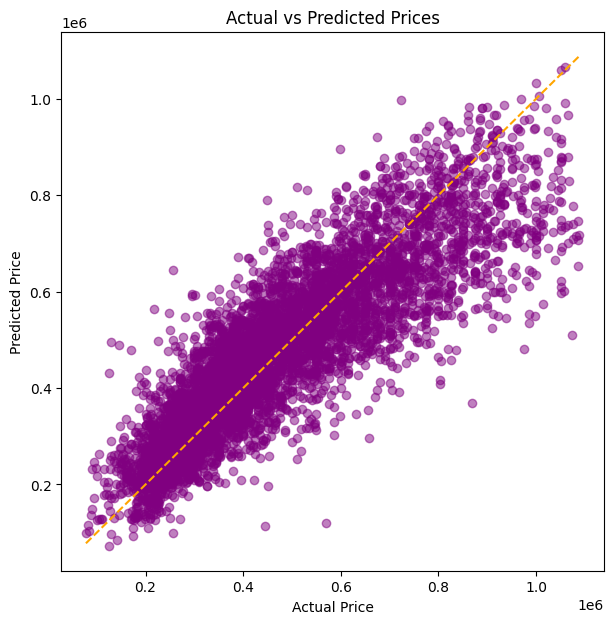

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(y_test, predicted_price, color='purple',alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='orange', linestyle='--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()


### Ridge

In [ ]:
grid_search.best_params_

{'linear_reg__fit_intercept': True}

In [ ]:
cross_val_score(pipeline_tuned, X_test, y_test, scoring = 'neg_root_mean_squared_error').mean() # neg_mean_absolute_error neg_root_mean_squared_error

-102729.67473231007

### Ridge

In [ ]:
to_ordinal_encode = ['grade', 'bathrooms', 'zipcode_class']
to_scale = ['sqft_living', 'sqft_living15']
select_features = to_scale + to_ordinal_encode

X = clean_df[select_features]
y = clean_df.price

model_name = 'ridge'
rmse_list = []
for i in range(1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001)) # np.random.randint(1, 20001) 42

    # Building Pipeline
    preprocessor = ColumnTransformer([
        # ('imputer', SimpleImputer(strategy='most_frequent')),
        # ('onehot', OneHotEncoder(), to_one_hot_encode),
        ('ordinal', OrdinalEncoder(), to_ordinal_encode),
        ('robust_scaler', RobustScaler(), to_scale), # RobustScaler/StandardScaler/MinMaxScaler
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('ridge', Ridge())
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid={
            'ridge__alpha'           : [1,10, 0.1,0.01,0],
            "ridge__fit_intercept"   : [True, False],
            "ridge__solver"          : ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
            "ridge__max_iter"        : [10000]
        },
        cv=5,
        scoring="neg_root_mean_squared_error")



    grid_search.fit(X_train, y_train)
    pipeline_tuned = grid_search.best_estimator_
    # pipeline.fit(X_train, y_train)

    # Is there a missing transform ? don't think so.
    predicted_price = pipeline_tuned.predict(X_test)

    rmse_score = round(np.sqrt(mean_squared_error(y_test, predicted_price)))
    rmse_list.append(rmse_score)
    save_model_if_best(rmse_score, pipeline_tuned, model_name)

# Display RMSE
print(f"# Average prediction error: ~{round(np.mean(rmse_list)):.4f} (RMSE) (min-max:{round(min(rmse_list))}-{round(max(rmse_list))}), {np.mean(rmse_list)/clean_df.price.mean()*100}% of average price")

print(f"# Used features : {len(select_features) } - {select_features}") #/len(df.columns)

102125
# Average prediction error: ~102125.0000 (RMSE) (min-max:102125-102125), 21.551320235221795% of average price
# Used features : 5 - ['sqft_living', 'sqft_living15', 'grade', 'bathrooms', 'zipcode_class']


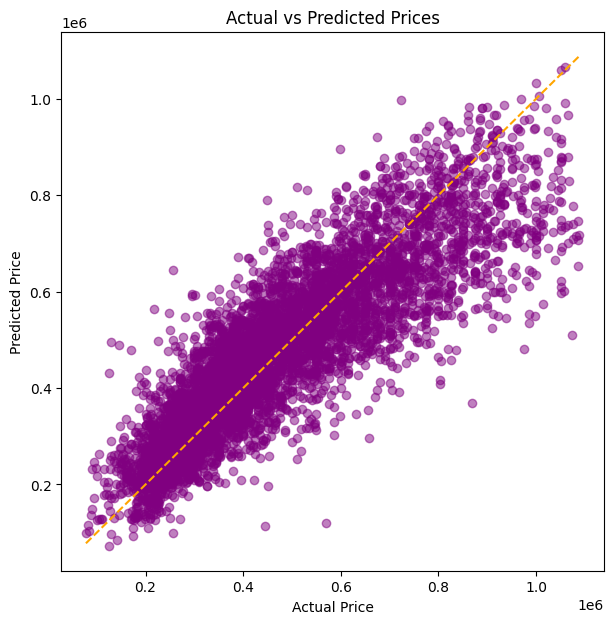

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(y_test, predicted_price, color='purple',alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='orange', linestyle='--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()


In [ ]:
grid_search.best_params_

{'ridge__alpha': 0.1,
 'ridge__fit_intercept': True,
 'ridge__max_iter': 10000,
 'ridge__solver': 'sag'}

In [ ]:
cross_val_score(pipeline_tuned, X_test, y_test, scoring = 'neg_root_mean_squared_error').mean() # neg_mean_absolute_error neg_root_mean_squared_error

-101665.02566672968

### DecisionTreeRegressor

In [ ]:
to_ordinal_encode = ['grade'] # 'bathrooms', 'zipcode_class'
to_scale = ['sqft_living', 'sqft_living15']
select_features = to_scale + to_ordinal_encode

X = clean_df[select_features]
y = clean_df.price

model_name = 'decisionTree'
rmse_list = []
for i in range(1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001)) # np.random.randint(1, 20001) 42

    # Building Pipeline
    preprocessor = ColumnTransformer([
        # ('imputer', SimpleImputer(strategy='most_frequent')),
        # ('onehot', OneHotEncoder(), to_one_hot_encode),
        ('ordinal', OrdinalEncoder(), to_ordinal_encode),
        ('robust_scaler', RobustScaler(), to_scale), # RobustScaler/StandardScaler/MinMaxScaler
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('decision_tree', DecisionTreeRegressor())
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid={
            "decision_tree__splitter":["best","random"],
            "decision_tree__max_depth" : [1,3,5,9],
            "decision_tree__min_samples_leaf":[1,2,3,5],
            "decision_tree__min_weight_fraction_leaf":[0.1,0.2,0.5],
            "decision_tree__max_features":["log2","sqrt",None, 0.1, 1, 10],
            "decision_tree__max_leaf_nodes":[None,10,30,50]
        },
        cv=5,
        scoring="neg_root_mean_squared_error")

    grid_search.fit(X_train, y_train)
    pipeline_tuned = grid_search.best_estimator_
    # pipeline.fit(X_train, y_train)

    # Is there a missing transform ? don't think so.
    predicted_price = pipeline_tuned.predict(X_test)

    rmse_score = round(np.sqrt(mean_squared_error(y_test, predicted_price)))
    rmse_list.append(rmse_score)
    save_model_if_best(rmse_score, pipeline_tuned, model_name)

# Display RMSE
print(f"# Average prediction error: ~{round(np.mean(rmse_list)):.4f} (RMSE) (min-max:{round(min(rmse_list))}-{round(max(rmse_list))}), {np.mean(rmse_list)/clean_df.price.mean()*100}% of average price")


print(f"# Used features : {len(select_features) } - {select_features}") #/len(df.columns)

# Average prediction error: ~157494.0000 (RMSE) (min-max:157494-157494), 33.2357760501936% of average price
# Used features : 3 - ['sqft_living', 'sqft_living15', 'grade']


In [ ]:
grid_search.best_params_

{'decision_tree__max_depth': 5,
 'decision_tree__max_features': None,
 'decision_tree__max_leaf_nodes': None,
 'decision_tree__min_samples_leaf': 1,
 'decision_tree__min_weight_fraction_leaf': 0.1,
 'decision_tree__splitter': 'best'}

In [ ]:
cross_val_score(pipeline_tuned, X_test, y_test, scoring = 'neg_root_mean_squared_error').mean() # neg_mean_absolute_error neg_root_mean_squared_error

-125464.50858268145

### ElasticNet

In [ ]:
from sklearn.linear_model import ElasticNet

In [ ]:
to_ordinal_encode = ['grade', 'bathrooms', 'zipcode_class']
to_scale = ['sqft_living', 'sqft_living15']
select_features = to_scale + to_ordinal_encode

X = clean_df[select_features]
y = clean_df.price

model_name = 'elasticNet'
rmse_list = []
for i in range(1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001)) # np.random.randint(1, 20001) 42

    # Building Pipeline
    preprocessor = ColumnTransformer([
        # ('imputer', SimpleImputer(strategy='most_frequent')),
        # ('onehot', OneHotEncoder(), to_one_hot_encode),
        ('ordinal', OrdinalEncoder(), to_ordinal_encode),
        ('robust_scaler', RobustScaler(), to_scale), # RobustScaler/StandardScaler/MinMaxScaler
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('elasticNet', ElasticNet(max_iter = 5000))
    ])


    grid_search = GridSearchCV(
        pipeline,
        param_grid={
            'elasticNet__alpha'           : [1,10,0.1,0.01,0.001,0.0001],
            "elasticNet__l1_ratio"        : [1,0.5, 0.1,0],
            "elasticNet__fit_intercept"   : [True, False],
            "elasticNet__tol"             : [1,0.1,0.01,0.001,0.0001, 0.00001, 0],

        },
        cv=5,
        scoring="neg_root_mean_squared_error")



    grid_search.fit(X_train, y_train)
    pipeline_tuned = grid_search.best_estimator_
    # pipeline.fit(X_train, y_train)

    # Is there a missing transform ? don't think so.
    predicted_price = pipeline_tuned.predict(X_test)

    rmse_score = round(np.sqrt(mean_squared_error(y_test, predicted_price)))
    rmse_list.append(rmse_score)
    save_model_if_best(rmse_score, pipeline_tuned, model_name)

# Display RMSE
print(f"# Average prediction error: ~{round(np.mean(rmse_list)):.4f} (RMSE) (min-max:{round(min(rmse_list))}-{round(max(rmse_list))}), {np.mean(rmse_list)/clean_df.price.mean()*100}% of average price")

print(f"# Used features : {len(select_features) } - {select_features}") #/len(df.columns)

/Users/julien.ract.mugnerot/.pyenv/versions/3.12.0/envs/apartment-hunter/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.812e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/julien.ract.mugnerot/.pyenv/versions/3.12.0/envs/apartment-hunter/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.969e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/julien.ract.mugnerot/.pyenv/versions/3.12.0/envs/apartment-hunter/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objecti

101429
# Average prediction error: ~101429.0000 (RMSE) (min-max:101429-101429), 21.404444162921042% of average price
# Used features : 5 - ['sqft_living', 'sqft_living15', 'grade', 'bathrooms', 'zipcode_class']


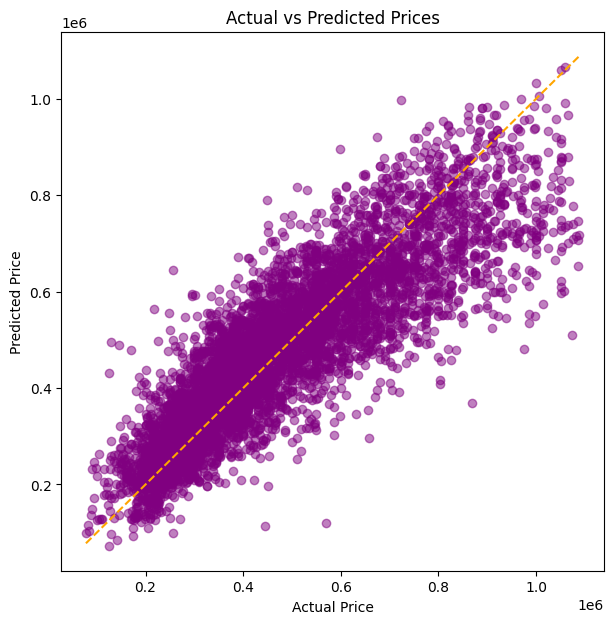

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(y_test, predicted_price, color='purple',alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='orange', linestyle='--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()


In [ ]:
grid_search.best_params_

{'elasticNet__alpha': 10,
 'elasticNet__fit_intercept': True,
 'elasticNet__l1_ratio': 1,
 'elasticNet__tol': 0.1}

In [ ]:
cross_val_score(pipeline_tuned, X_test, y_test, scoring = 'neg_root_mean_squared_error').mean() # neg_mean_absolute_error neg_root_mean_squared_error

-101407.5667634323

### SVM(SVR)

In [ ]:
to_ordinal_encode = ['grade', 'zipcode_class']
to_scale = ['sqft_living', 'sqft_living15']
select_features = to_scale + to_ordinal_encode

X = clean_df[select_features]
y = clean_df.price

model_name = 'svr'
rmse_list = []
for i in range(1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001)) # np.random.randint(1, 20001) 42

    # Building Pipeline
    preprocessor = ColumnTransformer([
        # ('imputer', SimpleImputer(strategy='most_frequent')),
        # ('onehot', OneHotEncoder(), to_one_hot_encode),
        ('ordinal', OrdinalEncoder(), to_ordinal_encode),
        ('robust_scaler', RobustScaler(), to_scale), # RobustScaler/StandardScaler/MinMaxScaler
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('svr', SVR())
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid={
            'svr__C': [0.1, 1, 10],
            'svr__kernel': ['linear', 'rbf', 'poly'],
            'svr__gamma': ['scale', 'auto'],
            'svr__epsilon': [0.1, 0.5, 1.0],
            'svr__degree': [2, 3, 4]
        },
        cv=5,
        scoring="neg_root_mean_squared_error")



    grid_search.fit(X_train, y_train)
    pipeline_tuned = grid_search.best_estimator_
    # pipeline.fit(X_train, y_train)

    # Is there a missing transform ? don't think so.
    predicted_price = pipeline_tuned.predict(X_test)

    rmse_score = round(np.sqrt(mean_squared_error(y_test, predicted_price)))
    rmse_list.append(rmse_score)
    save_model_if_best(rmse_score, pipeline_tuned, model_name)

# Display RMSE
print(f"# Average prediction error: ~{round(np.mean(rmse_list)):.4f} (RMSE) (min-max:{round(min(rmse_list))}-{round(max(rmse_list))}), {np.mean(rmse_list)/clean_df.price.mean()*100}% of average price")
# cross_val_score(pipeline_tuned, X_test, y_test, scoring = 'neg_root_mean_squared_error').mean()

print(f"# Used features : {len(select_features) } - {select_features}") #/len(df.columns)
print(grid_search.best_params_)

new model ran
# Average prediction error: ~117827.0000 (RMSE) (min-max:117827-117827), 24.86489507324826% of average price
# Used features : 4 - ['sqft_living', 'sqft_living15', 'grade', 'zipcode_class']
{'svr__C': 10, 'svr__degree': 2, 'svr__epsilon': 0.1, 'svr__gamma': 'auto', 'svr__kernel': 'poly'}


In [ ]:
cross_val_score(pipeline_tuned, X_test, y_test, scoring = 'neg_root_mean_squared_error').mean() # neg_mean_absolute_error neg_root_mean_squared_error

KNN Regressor

In [ ]:
to_ordinal_encode = ['grade', 'zipcode_class'] # 'bathrooms'
to_scale = ['sqft_living', 'sqft_living15']
select_features = to_scale + to_ordinal_encode

X = clean_df[select_features]
y = clean_df.price

model_name = 'knn'
rmse_list = []

for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 20001)) # np.random.randint(1, 20001) 42

    # Building Pipeline
    preprocessor = ColumnTransformer([
        # ('imputer', SimpleImputer(strategy='most_frequent')),
        # ('onehot', OneHotEncoder(), to_one_hot_encode),
        ('ordinal', OrdinalEncoder(), to_ordinal_encode),
        ('robust_scaler', RobustScaler(), to_scale), # RobustScaler/StandardScaler/MinMaxScaler
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('knn', KNeighborsRegressor(n_jobs=-1))
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid={
            'knn__n_neighbors': range(10, 105, 5)
        },
        cv=5,
        scoring="neg_root_mean_squared_error")



    grid_search.fit(X_train, y_train)
    pipeline_tuned = grid_search.best_estimator_
    # pipeline.fit(X_train, y_train)

    # Is there a missing transform ? don't think so.
    predicted_price = pipeline_tuned.predict(X_test)

    rmse_score = round(np.sqrt(mean_squared_error(y_test, predicted_price)))
    rmse_list.append(rmse_score)
    save_model_if_best(rmse_score, pipeline_tuned, model_name)

# Display RMSE
print(f"# Average prediction error: ~{round(np.mean(rmse_list)):.4f} (RMSE) (min-max:{round(min(rmse_list))}-{round(max(rmse_list))}), {np.mean(rmse_list)/clean_df.price.mean()*100}% of average price")

print(f"# Used features : {len(select_features) } - {select_features}") #/len(df.columns)
print(grid_search.best_params_)

96308
# Average prediction error: ~99767.0000 (RMSE) (min-max:96308-102492), 21.053684687613607% of average price
# Used features : 4 - ['sqft_living', 'sqft_living15', 'grade', 'zipcode_class']
{'knn__n_neighbors': 55}


XGBoost

In [ ]:
from xgboost import XGBRegressor

XGBRegressor(max_depth=10, n_estimators=100, learning_rate=0.1)

to_ordinal_encode = ['grade', 'zipcode_class'] # 'bathrooms'
to_scale = ['sqft_living', 'sqft_living15']
select_features = to_scale + to_ordinal_encode

X = clean_df[select_features]
y = clean_df.price

model_name = 'xgboost'
rmse_list = []

for i in range(25):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, \
        random_state=np.random.randint(1, 40001)) # np.random.randint(1, 20001) 42

    # Building Pipeline
    preprocessor = ColumnTransformer([
        # ('imputer', SimpleImputer(strategy='most_frequent')),
        # ('onehot', OneHotEncoder(), to_one_hot_encode),
        ('ordinal', OrdinalEncoder(), to_ordinal_encode),
        ('robust_scaler', RobustScaler(), to_scale), # RobustScaler/StandardScaler/MinMaxScaler
    ], remainder='passthrough')  # passthrough/drop

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('xgboost', XGBRegressor(max_depth=10, n_estimators=100, learning_rate=0.1))
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid={
            'xgboost__n_estimators' : [25, 40, 50,100],
            'xgboost__max_depth' : [2, 4, 6, 8,10,12],
            'xgboost__learning_rate' : [0.1, 0.3, 0.5]
        },
        cv=5,
        scoring="neg_root_mean_squared_error")

    grid_search.fit(X_train, y_train)
    pipeline_tuned = grid_search.best_estimator_
    # pipeline.fit(X_train, y_train)

    # Is there a missing transform ? don't think so.
    predicted_price = pipeline_tuned.predict(X_test)

    rmse_score = round(np.sqrt(mean_squared_error(y_test, predicted_price)))
    rmse_list.append(rmse_score)
    save_model_if_best(rmse_score, pipeline_tuned, model_name)

# Display RMSE
print(f"# Average prediction error: ~{round(np.mean(rmse_list)):.4f} (RMSE) (min-max:{round(min(rmse_list))}-{round(max(rmse_list))}), {np.mean(rmse_list)/clean_df.price.mean()*100}% of average price")

print(f"# Used features : {len(select_features) } - {select_features}") #/len(df.columns)
print(grid_search.best_params_)

97406
97121
# Average prediction error: ~99067.0000 (RMSE) (min-max:97121-101828), 20.906019367453077% of average price
# Used features : 4 - ['sqft_living', 'sqft_living15', 'grade', 'zipcode_class']
{'xgboost__learning_rate': 0.1, 'xgboost__max_depth': 4, 'xgboost__n_estimators': 100}


# Project Conclusion

Well, our result are meh

In [ ]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(RobustScaler(), LinearRegression())
pipeline.fit(X_train.drop(columns=['zipcode_class', 'bathrooms']), y_train)

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.drop(columns=['zipcode_class', 'bathrooms']).values, mode='regression')

instance = X_test.drop(columns=['zipcode_class', 'bathrooms']).iloc[0]


explanation = explainer.explain_instance(instance.values, pipeline.predict, num_features=len(instance))


explanation.show_in_notebook()
X_train.columns

/home/julienrm/.pyenv/versions/3.8.12/envs/apartment-hunter/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Index(['sqft_living', 'sqft_living15', 'grade', 'bathrooms', 'zipcode_class'], dtype='object')

In [ ]:
# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

#Numerical features for distribution analysis
numerical_features = ['age', 'avg_glucose_level', 'bmi']

# Plot the distribution of numerical features
plt.figure(figsize=(15, 5))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[feature], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()



#Categorical features for distribution analysis
categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Plot the distribution of categorical features
plt.figure(figsize=(15, 15))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)
    sns.countplot(y=df[feature])
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

In [ ]:
bins = [0, 2, 18, 35, 65, np.inf]
labels = ['Infant', 'Child', 'Young Adult', 'Adult', 'Senior']
df_age = data.copy()
df_age['age_group'] = pd.cut(df_age['age'], bins=bins, labels=labels, right=False)

sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(10, 10))
sns.histplot(df_age["age_group"], label="age_group", kde=True)
plt.title("Distribution of age_groupLevel")

In [ ]:
# Define the labels and values for the pie plot
labels = ['No Stroke', 'Stroke']
values = data.stroke.value_counts()

# Define the explode values to separate the slices
explode = (0, 0.1)

# Plot the pie plot
plt.pie(values, labels=labels, explode=explode, shadow=True, autopct='%1.1f%%')

# Add a title to the plot
plt.title('Distribution of Stroke')

# Display the plot
plt.show()


In [ ]:
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(10, 10))
sns.histplot(data["avg_glucose_level"], label="avg_glucose_level", kde=True)
plt.title("Distribution of Average Glucose Level")


In [ ]:
sns.set_theme(style="darkgrid")
fig = plt.figure(figsize=(10, 10))
sns.histplot(data["bmi"], label="bmi", kde=True)
plt.title("Distribution of BMI")

In [ ]:
plt.figure(figsize=(10, 10))
sns.histplot(data,
             x="bmi", hue="stroke",
             element="step",
             stat="density", common_norm=False)
plt.title("Distribution of BMI by Stroke")
plt.show()


In [ ]:
q1, q9 = data["bmi"].quantile([0.1, 0.9])

mask = data["bmi"].between(q1, q9)
mask.head()

In [ ]:
q1, q9 = data["bmi"].quantile([0.1, 0.9])
mask = data["bmi"].between(q1, q9)
sns.boxplot(x="stroke", y="bmi" , data=data[mask])
plt.xlabel("stroke")
plt.ylabel("bmi")
plt.title("Distribution of stroke/bmi Ratio, by Class")

In [ ]:
q1, q9 = data["avg_glucose_level"].quantile([0.1, 0.9])
mask = data["avg_glucose_level"].between(q1, q9)
sns.boxplot(x="stroke", y="bmi" , data=data[mask])
plt.xlabel("stroke")
plt.ylabel("avg_glucose_level")
plt.title("Distribution of stroke/avg_glucose_level Ratio, by Class")

In [ ]:
#Randpom under sampling
under_sampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)
print(X_train_under.shape)
X_train_under.head()

In [ ]:
#Random over sampling
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print(X_train_over.shape)
X_train_over.head()

In [ ]:
#Smote sampling
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
print(X_train_sm.shape)
X_train_sm.head()

In [ ]:
# Get importances
importances = model_reg.named_steps["decisiontreeclassifier"].feature_importances_

# Put importances into a Series
feat_imp = pd.Series(importances, index=X_train_over.columns).sort_values()

# Plot series
feat_imp.tail(15).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("model_over Feature Importance")

In [ ]:
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test)

In [ ]:
# custom_palette = {'Unknown': '#275375', 'formerly smoked': '#824b0d', 'never smoked': '#e08610', 'smokes': '#532e59'}

# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# sns.countplot(x='stroke', hue='smoking_status', data=clean_df[clean_df.stroke ==0], palette=custom_palette, ax=axs[0])
# sns.countplot(x='stroke', hue='smoking_status', data=clean_df[clean_df.stroke ==1], palette=custom_palette, ax=axs[1])

# axs[0].set_title('No Stroke')
# axs[1].set_title('Stroke')
# axs[1].legend_.remove()

# plt.show()
